In [1]:
import pandas as pd
import tensorflow as tf , re
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
import itertools , dill , umap , seaborn as sns
import matplotlib.pyplot as plt , calendar
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/home/advice/Python/SR/Custom/')
from RAdam import RAdamOptimizer
from jupyter_tensorboard import *
from utility import *
from Activations import *
from Losses import *
from wasserstein import Wasserstein
from IPython.display import clear_output
import os , collections , warnings
from collections import Counter
import missingno as msno , math
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import keras.backend as k
static = os.path.abspath("./Result")
ModelName = "IITP_GAN_Target_1"
ModelResult = "Models"
ResultPath = os.path.join(static , ModelName)    
ModelResultPath = os.path.join(ResultPath , ModelResult)
if tf.io.gfile.exists(ResultPath) :
    tf.io.gfile.rmtree(ResultPath)
    tf.io.gfile.makedirs(ResultPath)
    tf.io.gfile.makedirs(ModelResultPath)
else :
    tf.io.gfile.makedirs(ResultPath)

/root/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)



    사용하면 좋은 패키지
    st / train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1533107414175758379
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3140131498687679160
physical_device_desc: "device: XLA_CPU device"
]


Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path = "/var/disk/total_2020_change_v2.ftr"
data = pd.read_feather(path)

In [4]:
with open('./total_2020_IITP_v2.pkl', 'rb') as rb :
    information = dill.load(rb)

In [5]:
vartypes = deepcopy(information["vartype"])
deletecol = ["farm_no_fake", "occur", "dt"]
for i in deletecol :
    del vartypes[i]
totalcols = data.columns.tolist()
controlcol = ["LATITUDE","LONGITUDE","month_day"]
#[totalcols.remove(i) for i in deletecol + controlcol]

In [6]:
for i in deletecol + controlcol : 
    try :
        totalcols.remove(i)
    except :
        continue

In [7]:
numcol , faccol = [] , []
for key , value in vartypes.items() :
    if key in totalcols :
        if value == "numeric" : numcol.append(key)
        else : faccol.append(key)

In [8]:
fac_uni_info = {}
for fac in faccol :
    result = data[fac].unique().tolist()
    result = np.array(result)[~np.isnan(result)].tolist()
    fac_uni_info[fac] = result

In [9]:
data = data[data.occur == 1]
data.drop(["occur"], axis=1, inplace = True)
data = data.reset_index(drop=True)
controlcol = ["LATITUDE","LONGITUDE","month_day"]
control_variables = data[controlcol]
data.drop(controlcol,axis = 1 , inplace=True)

In [10]:
farm = data.pop("farm_no_fake")

In [11]:
for col in faccol :
    data[col] = pd.Series(pd.Categorical(data[col] , categories=fac_uni_info[col],ordered=False))

In [12]:
m = MinMaxScaler(feature_range=(-1,1))
m.fit(data[numcol])
data[numcol] = m.fit_transform(data[numcol])

In [13]:
from scipy.stats import wasserstein_distance as wdist
from IITPutils import *

In [14]:
totalcol = numcol + faccol
data = data[totalcol]

In [15]:
missing_data = (data.isna().values == 1) * 1
miss_sum = data.isna().sum() 
raw_dim = missing_data.shape[1]

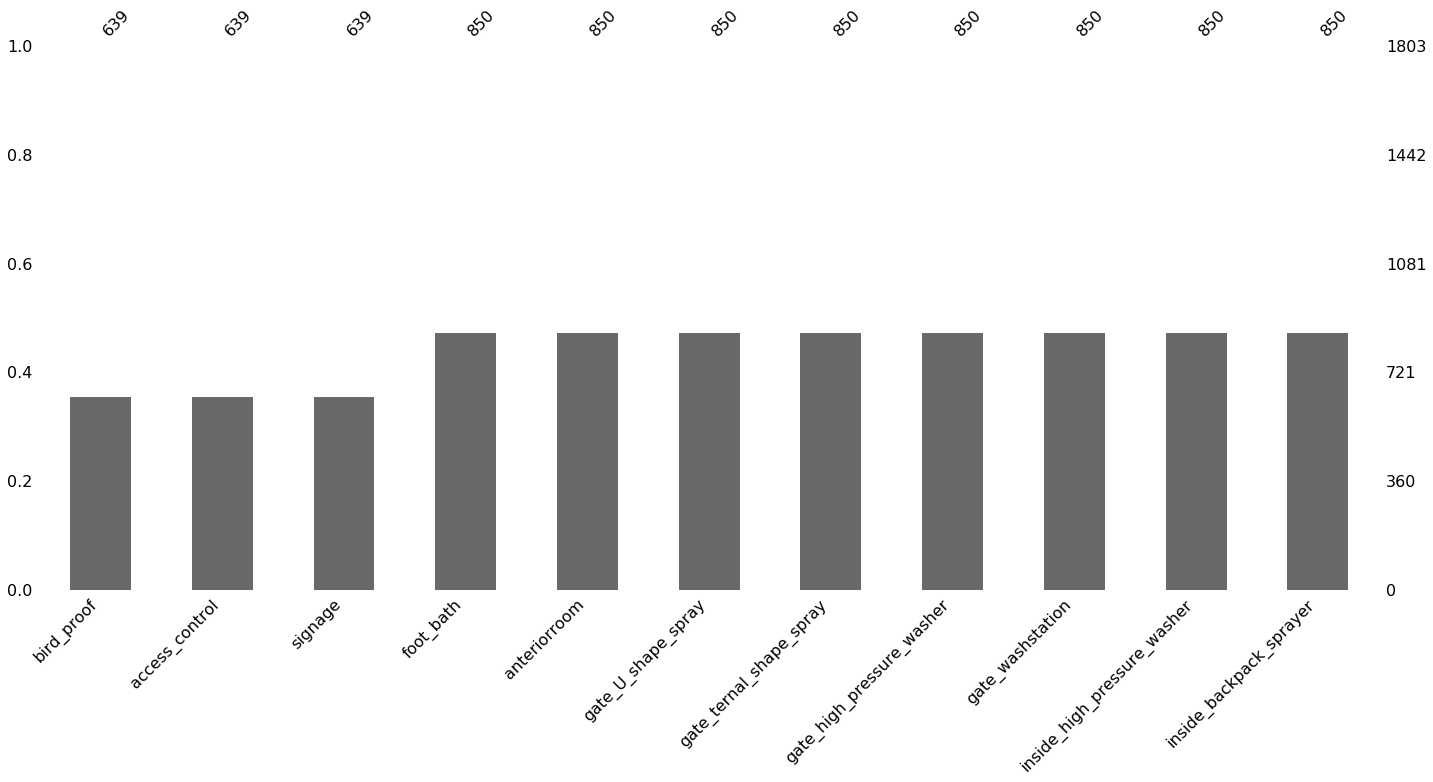

In [16]:
miss_var = miss_sum[miss_sum > 0 ].index.tolist()
msno.bar(data[miss_var])
plt.show()

In [17]:
OneHotdata = pd.get_dummies(data, columns= faccol , dummy_na = False)

In [18]:
f"ONE HOT before : {data.shape} -> after : {OneHotdata.shape}"

'ONE HOT before : (1803, 41) -> after : (1803, 91)'

In [19]:
one_hot_var = OneHotdata.columns.tolist()

In [20]:
onehot_key_store , store = OneHotIndex(totalcol , numcol , one_hot_var)
data.head()

,chicken,turkey,duck,goose,quail,ornamental_bird,pheasant,ostrich,wild_bird,wild_duck,...,access_control,signage,foot_bath,anteriorroom,gate_U_shape_spray,gate_ternal_shape_spray,gate_high_pressure_washer,gate_washstation,inside_high_pressure_washer,inside_backpack_sprayer
0,-1.000,-1.0,-0.459459,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.925,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.000,-1.0,-0.459459,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.925,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.000,-1.0,-0.459459,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
## if missing : 1 else 0
MissIndicator = CreateMissIndicator(OneHotdata , store , numcol)

In [22]:
only_one_hot = list(set(one_hot_var).difference(set(numcol)))

In [23]:
data[faccol].head()

,grow_other_species_except_for_poultry,bird_proof,access_control,signage,foot_bath,anteriorroom,gate_U_shape_spray,gate_ternal_shape_spray,gate_high_pressure_washer,gate_washstation,inside_high_pressure_washer,inside_backpack_sprayer
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
pd.DataFrame(MissIndicator, columns= one_hot_var)[np.sort(only_one_hot)].head()

,access_control_0.0,access_control_1.0,anteriorroom_0.0,anteriorroom_1.0,anteriorroom_10.0,anteriorroom_12.0,anteriorroom_15.0,anteriorroom_16.0,anteriorroom_2.0,anteriorroom_21.0,...,gate_washstation_0.0,gate_washstation_1.0,grow_other_species_except_for_poultry_0.0,grow_other_species_except_for_poultry_1.0,inside_backpack_sprayer_0.0,inside_backpack_sprayer_1.0,inside_high_pressure_washer_0.0,inside_high_pressure_washer_1.0,signage_0.0,signage_1.0
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# 결측치 처리
* numerical variable은 그대로 사용
* categorical variable 결측치를 고민중
    * 기존과 동일하게 sigmoid로 하고 나서, 0이면 0으로 채우고 1이면 1로 채우는 형태로하기
    * 그리고 한개의 값으로 추출할 때는 na로 만들기

In [25]:
overall_where = []
for key , values in onehot_key_store.items() :
    first , to = values
    diff = to-first
    if diff == 1 :
        final = to
        continue
    else :
        if len(overall_where) == 0 :
            overall_where.append([0,final])
            overall_where.append(values)
        else :
            overall_where.append(values)

In [26]:
overall_where

[[0, 29],
 [29, 31],
 [31, 33],
 [33, 35],
 [35, 37],
 [37, 64],
 [64, 79],
 [79, 81],
 [81, 83],
 [83, 85],
 [85, 87],
 [87, 89],
 [89, 91]]

In [27]:
BATCH_SIZE = 5000
n_dim = len(OneHotdata.columns.tolist())
raw_dim = raw_dim
g_dim = len(OneHotdata.columns.tolist())
noise = generate_noise(BATCH_SIZE, g_dim)
noise.shape 

(5000, 91)

In [28]:
def generator(Z , condition ,  bn , is_training , 
              onehot_key_store = onehot_key_store, reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        with tf.device('/device:CPU:0'):
            Z = tf.concat([Z, condition], axis = 1)
            d1 = tf.layers.dense(Z , 5*5*8)
            d1 = mish(d1)
            d2 = tf.reshape( d1 , [-1,5,5,8] )
            deconv = upconvolution(d2, output_channel_size=4,
                                   filter_size_h=3, filter_size_w=3,
                                   stride_h=1, stride_w=1, 
                                   layer_name = "deconv1" , 
                                   bn = bn , is_training = is_training , 
                                   activation = tf.nn.leaky_relu , 
                                   type = "xavier_uniform" , 
                                   data_format="NHWC", padding='VALID')
            deconv = upconvolution(deconv, output_channel_size=4,
                                   filter_size_h=3, filter_size_w=3,
                                   stride_h=1, stride_w=1, 
                                   layer_name = "deconv2" , 
                                   bn = bn , is_training = is_training , 
                                   activation = tf.nn.leaky_relu , 
                                   type = "xavier_uniform" , 
                                   data_format="NHWC", padding='VALID')
            deconv = upconvolution(deconv, output_channel_size=4,
                                   filter_size_h=3, filter_size_w=3,
                                   stride_h=1, stride_w=1, 
                                   layer_name = "deconv3" , 
                                   bn = bn , is_training = is_training , 
                                   activation = tf.nn.leaky_relu , 
                                   type = "xavier_uniform" , 
                                   data_format="NHWC", padding='VALID')
            ##############################################################
            d3 = tf.contrib.layers.flatten(deconv)
            d3 = fully_connected_layer(d3, n_dim + 20 , "G_FC1", mish , 
                                       usebias = True , final = False,
                                       SN = True , Type ="Self_Normal")
            d3 = fully_connected_layer(d3, n_dim + 20 , "G_FC2", mish , 
                                       usebias = True , final = False,
                                       SN = True , Type ="Self_Normal")
            out = fully_connected_layer(d3, n_dim , "G_Final" , 
                                        usebias = True , final = True,
                                        SN = True , Type =None, activation =None)
            values = VariableHandling(out , onehot_key_store)
            x_input , r_input , arg_input = values
            gene = tf.concat(x_input , axis = 1 , name = "gene_raw" ) 
            gene_x = tf.concat(r_input , axis = 1 , name = "gene_onehot" )
            gene_arg_x = tf.concat(arg_input , axis = 1 , name= "gene_args")
            train_var = [gene,gene_x,gene_arg_x]
            tf.add_to_collection('weight_variables', gene_arg_x)
            tf.add_to_collection('G_probs', train_var[0])
            tf.add_to_collection('G_onehot', train_var[1])
            tf.add_to_collection('G_argmax', train_var[2])
    return [out , gene , gene_x , gene_arg_x]


def MissGenerator(gene , condition , reuse = False) :
    with tf.variable_scope("GAN/MissGenerator",reuse=reuse):
        with tf.device('/device:CPU:0'):
            gene_cond = tf.concat([gene, condition], axis = 1)
            miss_out = fully_connected_layer(gene_cond, raw_dim*2 , "G_Miss1" , 
                                             usebias = False , final = False,
                                             SN = True , Type ="Self_Normal", activation = tf.nn.leaky_relu)
            miss_out = fully_connected_layer(miss_out, int(raw_dim * 1.5) , "G_Miss2" , 
                                        usebias = False , final = False,
                                        SN = True , Type ="Self_Normal", activation = tf.nn.leaky_relu)
            miss_out = fully_connected_layer(miss_out, raw_dim , "G_Miss_Final" , 
                                        usebias = True , final = False,
                                        SN = True , Type =None, activation = tf.nn.sigmoid)
            #tf.add_to_collection('weight_variables', miss_out)
            tf.add_to_collection('G_missindicator', miss_out)
    return miss_out
    

def discriminator(X,condition , gpu_n=1  , hsize=[300, 200 , 100,50],reuse=True):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        with tf.device(f'/device:CPU:0'):
            X = tf.concat([X, condition], axis = 1)
            for idx , h in enumerate(hsize) :
                if idx == 0 :
                    h1 = fully_connected_layer(X, h , f"D_FC{idx}", tf.nn.leaky_relu , 
                                               usebias = True , final = False,
                                               SN = True , Type ="Self_Normal")
                else :
                    h1 = fully_connected_layer(h1, h , f"D_FC{idx}", tf.nn.leaky_relu , 
                                               usebias = True , final = False,
                                               SN = True , Type ="Self_Normal")
            out = fully_connected_layer(h1, 1 , f"D_Final", None , 
                                       usebias = True , final = True,
                                       SN = False , Type =None)
            tf.add_to_collection('weight_variables', out)
    return tf.nn.sigmoid(out) , out

def MissDiscriminator(X, condition, gpu_n=1  , hsize=[300, 200 , 100,50],reuse=True):
    with tf.variable_scope("GAN/MissDiscriminator",reuse=reuse):
        with tf.device(f'/device:CPU:0') : 
            X = tf.concat([X, condition], axis = 1)
            for idx , h in enumerate(hsize) :
                if idx == 0 :
                    h1 = fully_connected_layer(X, h , f"D_Miss_FC{idx}", tf.nn.leaky_relu , 
                                               usebias = True , final = False,
                                               SN = True , Type ="Self_Normal")
                else :
                    h1 = fully_connected_layer(h1, h , f"D_Miss_FC{idx}", tf.nn.leaky_relu , 
                                               usebias = True , final = False,
                                               SN = True , Type ="Self_Normal")
            miss_out = fully_connected_layer(h1, 1 , "D_Miss_Indicator" , 
                                             usebias = True , final = False,
                                             SN = False , Type =None, activation = tf.nn.sigmoid)
            tf.add_to_collection('weight_variables', miss_out)
    return miss_out

def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])



In [29]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None, n_dim  ], name= "X")
missX = tf.placeholder(tf.float32,[None, raw_dim  ], name= "missX")
Z = tf.placeholder(tf.float32,[None, g_dim ] , name = "Z")
Conditions = tf.placeholder(tf.float32,[None, control_variables.shape[1] ] , name = "Condition")
batch_size = tf.placeholder(tf.int32,None , name="BatchSize")
is_training = tf.placeholder(tf.bool)
values = generator(Z, Conditions, bn= True , is_training = is_training)
out , G_sample , G_x , G_arg_x = values
G_miss = MissGenerator(G_sample , Conditions , reuse = False)
delta = tf.constant(0.5)
imputedX = tf.where( tf.math.is_nan(X) , tf.ones_like(X) * 1.5 , X)
miss_indicator = tf.where( G_miss > delta , tf.ones_like(G_miss)  , tf.zeros_like(G_miss)  )
miss_indicator.get_shape()

W0206 01:01:24.280646 140553339234048 deprecation.py:323] From <ipython-input-28-78485256e914>:6: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0206 01:01:24.284949 140553339234048 deprecation.py:323] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0206 01:01:24.327435 140553339234048 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPutils.py:70: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0206 01:01:24.340162 140553339234048 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPutils.py:72: The name tf.add_to_collection is deprecated. Please use tf.compat.v1.add_to_collection instead.

deconv1    output : [None, 7, 7, 4]
deconv2    output : [None, 9, 9, 4]
deconv3    output : [None, 11, 11, 4]


W0206 01:01:24.611529 140553339234048 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0206 01:01:24.612593 140553339234048 deprecation.py:323] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0206 01:01:24.621874 140553339234048 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPutils.py:183: The name tf.keras.initializers.he_uniform is deprecated. Please use tf.compat.v1.keras.initializers.he_uniform instead.

W0206 01:01:24

G_FC1      output : [None, 111]
G_FC2      output : [None, 111]
G_Final    output : [None, 91]
grow_other_species_except_for_poultry / diff : 2
bird_proof / diff : 2
access_control / diff : 2
signage / diff : 2
foot_bath / diff : 27
anteriorroom / diff : 15
gate_U_shape_spray / diff : 2
gate_ternal_shape_spray / diff : 2
gate_high_pressure_washer / diff : 2
gate_washstation / diff : 2
inside_high_pressure_washer / diff : 2
inside_backpack_sprayer / diff : 2


W0206 01:01:25.288939 140553339234048 deprecation.py:323] From <ipython-input-29-0a6e4a5ffeaa>:12: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


G_Miss1    output : [None, 82]
G_Miss2    output : [None, 61]
G_Miss_Final output : [None, 41]


TensorShape([Dimension(None), Dimension(41)])

In [30]:
miss_indicator2 , NumMissGenerator = MissGeneratorByVar(miss_indicator , overall_where)

In [31]:
miss_G_sample = G_sample * (1-miss_indicator2) + tf.constant([1.5]) * NumMissGenerator
miss_G_sample_eval = G_x * (1-miss_indicator2) + tf.constant([1.5]) * NumMissGenerator

In [32]:
# config=tf.ConfigProto(log_device_placement=True)
# config.gpu_options.allow_growth = True
# sess = tf.Session(config= config)
# train_writer = tf.summary.FileWriter(ModelResultPath,sess.graph)
# saver = tf.train.Saver()
# init = tf.global_variables_initializer()
# sess.run(init)
# Total_SIZE = len(data)
# Total_noise = generate_noise(Total_SIZE , g_dim)
# Total_onehot_X = OneHotdata.values
# Total_miss_data = missing_data
# Total_Conds = control_variables.values
# feed_dict={
#            X : Total_onehot_X ,
#            Z : Total_noise,
#            Conditions : Total_Conds, 
#            missX : Total_miss_data , 
#            batch_size : Total_SIZE , 
#            is_training : True , 
#            }
# result = sess.run(G_miss , feed_dict = feed_dict)

In [33]:
_ , real_logit  = discriminator(imputedX, Conditions , gpu_n=1 ,
                                 hsize=[400, 200,100,20] , 
                                reuse=False)
_ , fake_logit  = discriminator(miss_G_sample, Conditions, gpu_n=1,
                                hsize=[400, 200,100,20] , 
                                reuse=True)
miss_real_logit = MissDiscriminator(missX, Conditions,gpu_n=0 ,
                                    hsize=[450, 300,100,50] , 
                                    reuse=False)
miss_fake_logit = MissDiscriminator(miss_indicator, Conditions,gpu_n=0 ,
                                    hsize=[450, 300,100,50] , 
                                    reuse=True)

D_FC0      output : [None, 400]
D_FC1      output : [None, 200]
D_FC2      output : [None, 100]
D_FC3      output : [None, 20]
D_Final    output : [None, 1]
D_FC0      output : [None, 400]
D_FC1      output : [None, 200]
D_FC2      output : [None, 100]
D_FC3      output : [None, 20]
D_Final    output : [None, 1]
D_Miss_FC0 output : [None, 450]
D_Miss_FC1 output : [None, 300]
D_Miss_FC2 output : [None, 100]
D_Miss_FC3 output : [None, 50]
D_Miss_Indicator output : [None, 1]
D_Miss_FC0 output : [None, 450]
D_Miss_FC1 output : [None, 300]
D_Miss_FC2 output : [None, 100]
D_Miss_FC3 output : [None, 50]
D_Miss_Indicator output : [None, 1]


In [34]:
_ = [tf.summary.histogram(i.name , i ) for i in tf.get_collection("weight_variables")]

In [35]:

###########################################
e = tf.random_uniform([batch_size , 1] , 0 , 1)
x_hat =  e * imputedX + (1-e) * miss_G_sample
grad  = tf.gradients(discriminator(x_hat, Conditions,
                                   hsize=[400, 200,100,20] , 
                                   reuse=True , gpu_n=1 ) , x_hat)[0]
slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)

loss_func = "gan-gp"
##lsgan | agan | gan | gan-gp | dragan | hinge 
with tf.variable_scope("Discriminator_Loss") :
    with tf.variable_scope("Original_Loss"):
        disc_loss = discriminator_loss(Ra = True , loss_func=loss_func ,
                                       real= real_logit ,fake= fake_logit)
        disc_loss += gradient_penalty
    with tf.variable_scope("Indicator_Loss"):
        miss_disc_loss = discriminator_loss(Ra = True , loss_func=loss_func ,
                                       real= miss_real_logit ,fake= miss_fake_logit)
    #if loss_func in ["wgan-gp", "gan-gp"] :
    
with tf.variable_scope("Generator_Loss"):
    with tf.variable_scope("Original_Loss"):
        gen_loss = generator_loss(Ra = True ,loss_func= loss_func ,
                                  real = real_logit , fake = fake_logit )
    with tf.variable_scope("Indicator_Loss"):
        miss_gen_loss = generator_loss(Ra = True ,loss_func= loss_func ,
                                  real = miss_real_logit , fake = miss_fake_logit )
######################################################################
tf.summary.scalar(f"gradient_penalty_loss", gradient_penalty)
tf.summary.scalar(f"disc_loss", disc_loss)
tf.summary.scalar(f"miss_disc_loss", miss_disc_loss)
tf.summary.scalar(f"generate_loss", gen_loss)
tf.summary.scalar(f"miss_generate_loss", miss_gen_loss)

D_FC0      output : [None, 400]
D_FC1      output : [None, 200]
D_FC2      output : [None, 100]
D_FC3      output : [None, 20]
D_Final    output : [None, 1]


<tf.Tensor 'miss_generate_loss:0' shape=() dtype=string>

In [36]:
t_vars = tf.trainable_variables()
global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)

In [37]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")
miss_gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/MissGenerator")
miss_disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/MissDiscriminator")
gen_loss = gen_loss + miss_gen_loss
lr = 2e-4
# tf.train.RMSPropOptimizer
learning_rate = tf.train.exponential_decay(lr, global_step, decay_steps=100, decay_rate=0.98, staircase=True , )
with tf.variable_scope("Optimizer"):
    gen_step = RAdamOptimizer(learning_rate=learning_rate).minimize(gen_loss,
                                                                    var_list = gen_vars + miss_gen_vars ) # G Train step
    # + miss_disc_vars
    disc_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(disc_loss,
                                                                                var_list =disc_vars ) # D Train step
#     miss_gen_step = RAdamOptimizer(learning_rate=learning_rate).minimize(miss_gen_loss,
#                                                                     var_list = + gen_vars ) # G Train step
    miss_disc_step = RAdamOptimizer(learning_rate=learning_rate).minimize(miss_disc_loss,
                                                                          var_list = miss_disc_vars) # D Train step
    
    

W0206 01:01:32.110347 140553339234048 deprecation.py:506] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [38]:
from tensorflow.contrib.tensorboard.plugins import projector
merged = tf.summary.merge_all()
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config= config)
train_writer = tf.summary.FileWriter(ModelResultPath,sess.graph)
saver = tf.train.Saver()
init = tf.global_variables_initializer()
sess.run(init)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [39]:
# sess.run([miss_disc_step , gen_loss , disc_loss , miss_disc_loss,out], feed_dict = feed_dict)
import logging
log = logging.getLogger('iitp')
log.setLevel(logging.DEBUG)
fileHandler = logging.FileHandler(
    os.path.join(os.getcwd(),'iitp_target_1.txt') , mode= "w")
log.addHandler(fileHandler)
from SendMail import send_mail


In [40]:
steps = 99000
BATCH_SIZE = 600
ng_steps , nd_steps = 2, 5
global_distance = 0 
epochs = []
gen_loss_store = []
disc_loss_store = []
miss_disc_loss_store = []
total_distance_store = []
totalN = data.shape[1]
epoch = 0 

In [ ]:
for epoch in range(epoch , steps):
    print(f'iitp gan: {epoch:05d}/{steps}', end='\r')
    batch_idx = np.random.choice(len(data), BATCH_SIZE)
    batch_noise = generate_noise(BATCH_SIZE , g_dim)
    batch_onehot_X = OneHotdata.iloc[batch_idx,:].values
    batch_miss_data = missing_data[batch_idx , :]
    Conds = control_variables.values[batch_idx,:]
    feed_dict={global_step : epoch , 
               X : batch_onehot_X ,
               Z : batch_noise,
               Conditions : Conds, 
               missX : batch_miss_data , 
               batch_size : BATCH_SIZE , 
               is_training : True , 
               }
    n_gloss , n_dloss , n_missloss = 0 , 0 , 0 
    if epoch % 4 == 0 : ng_steps = 5
    else : ng_steps = 2
    for _ in range(ng_steps):
        # , miss_gen_step , miss_gen_loss
        _,gloss = sess.run([gen_step ,gen_loss ], 
                            feed_dict = feed_dict)
        n_gloss += gloss # + mgloss       
    for _ in range(nd_steps):
        _, dloss  = sess.run([disc_step, disc_loss] , 
                             feed_dict = feed_dict)
        n_dloss += dloss
    for _ in range(nd_steps):
        _, missloss  = sess.run([miss_disc_step, miss_disc_loss] , 
                             feed_dict = feed_dict)
        n_missloss += missloss
    
    n_gloss /= ng_steps
    n_dloss /= nd_steps
    n_missloss /= nd_steps
#     print(f"{n_gloss} {n_dloss} {n_missloss}", end='\n')
    if math.isnan(n_gloss) | math.isnan(n_dloss) | math.isnan(n_missloss) :
        msg = f"nan issue gloss : {n_gloss} , dloss : {n_dloss} , missloss : {n_missloss}"
        log.error(f"[{epoch}] Error : {msg}")
        send_mail(subject = "IITP GAN Train Error!!", txt = msg)
        sys.exit(0)
    per = 100
    if (epoch % per == 0) & (epoch > 0) :
        epochs.append(epoch)
        gen_loss_store.append(n_gloss)
        disc_loss_store.append(n_dloss)
        miss_disc_loss_store.append(n_missloss)
        fig , axes = plt.subplots(nrows=1 ,ncols=2, figsize=(15,8) )
        ax = axes.flatten()
        plt.subplots_adjust(left=0.05, bottom=0.2, right=0.85, 
                            top=0.95, wspace=None, hspace=0.0)
        ax[0].plot( epochs , gen_loss_store , label = "Generator")
        ax[0].plot( epochs, disc_loss_store , label = "Discriminator")
        ax[0].plot( epochs, miss_disc_loss_store , label = "MissDiscriminator")
        ax[0].set_title(f"Epoch : {epoch} GLoss : {n_gloss:.3f} DLoss : {n_dloss:.3f} MissDloss : {n_missloss:.3f}")
        ax[0].legend(loc=1)
        #plt.ylim(0,3)
        store = []
        Total_SIZE = len(data)
        Total_noise = generate_noise(Total_SIZE , g_dim)
        Total_onehot_X = OneHotdata.values
        Total_miss_data = missing_data
        Total_Conds = control_variables.values
        feed_dict={global_step : epoch , 
                   X : Total_onehot_X ,
                   Z : Total_noise,
                   Conditions : Total_Conds, 
                   missX : Total_miss_data , 
                   batch_size : Total_SIZE , 
                   is_training : True , 
                   }
#         miss_g , miss_indic ,miss_sigmoid,miss_x = sess.run([miss_G_sample_eval,miss_indicator2,
#                                                              G_miss,G_sample] , feed_dict = feed_dict)
        miss_g , miss_indic = sess.run([miss_G_sample_eval,miss_indicator2] , 
                                         feed_dict = feed_dict)
#         miss_g = np.where(miss_g==1.5, np.nan, miss_g) 
        total_msg = f"STEP : {epoch} \n"
        miss_g = missing_handling(miss_g , overall_where)
        print(pd.DataFrame(miss_g[[0],:], columns = totalcol))
        msg = f'{"="*10} Epoch : {epoch} {"="*10}'
        log.info(msg)
        log.info(miss_indic[[0],:])
        log.info(miss_g[[0],:])
        for i , _column_ in enumerate(data.columns.tolist()) :
            r = data.iloc[:,i].values.astype(float)
            g = miss_g[:,i] 
            r = r[~np.isnan(r)]
            g = g[~np.isnan(g)]
            try :
                dist = np.round(wdist(g, r),6)
            except Exception as e :
                print(f"{_column_} :  {e}")
                dist  = 0 
                pass
            store.append(dist)
            msg = r"[{}.{:.3f}]".format(i,dist)
            if int(data.shape[1] / 2)  == i :
                total_msg = total_msg + " \n"
            total_msg = total_msg + msg
        total_distance = sum(store)
        total_distance_store.append(total_distance)
        try :
            summary  = sess.run(merged , feed_dict = feed_dict)
            train_writer.add_summary(summary, epoch)
        except Exception as e:
            #log.error(f"[{epoch}] Error : {e}")
            pass
        if len(total_distance_store) == 1 :
            global_distance = total_distance
        
        if total_distance <= global_distance :
            msg = f"[{epoch}] distnace : {global_distance} -> {total_distance}"
            log.info(msg)
            global_distance = total_distance
            meta_graph_bool = True
            saver.save(sess, 
                       os.path.join(ModelResultPath , "model.ckpt" ), 
                       global_step= epoch, write_meta_graph = meta_graph_bool )
        total_msg = f"STEP : {epoch} \n"
        total_msg += f"Total Distance : {total_distance:.3f}[{min(total_distance_store):.3f}]"
        ax[1].plot(epochs , total_distance_store , label = "TotalDistance")
        ax[1].set_title(total_msg , fontsize= 12)
        ax[1].legend(loc=1)
        plt.tight_layout()
        plt.savefig(os.path.join(ResultPath, f'{epoch:05d}.png'))
        if epoch % 200 == 0 :
            clear_output()
        else :
            plt.show()
            
#     if epoch == steps-1 :
#         noise = generate_noise(10000)
#         onehot_target = onehot_data.sample(10000).values
#         feed_dict={global_step : epoch , 
#                    X : onehot_target ,
#                    is_training : True , 
#                    Z : noise}
#         generated_points , arg_points = sess.run([G_x , G_arg_x] , feed_dict = feed_dict)
#         info["generated_points"]= generated_points
#         info["arg_points"]= arg_points
log.info("Terminate")

In [ ]:
import os
os.system('convert -delay 15 -loop 0 {0}/*.png {0}/gan.gif'.format(ResultPath))

In [ ]:
ModelResultPath = os.path.join(ResultPath , ModelResult)

In [ ]:
send_mail(subject = "IITP GAN Train Target 1 Complete",
          txt = f"결과물 경로 : {ResultPath}",
          gifpath = os.path.join(ResultPath, "gan.gif"))